<a href="https://www.kaggle.com/code/ataturhan/titanic?scriptVersionId=199792742" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import joblib

# Setting visual styles
plt.style.use('ggplot')
sns.set_context('notebook')

# Set Constants and Other Configuration

In [3]:
HO_TUNING = False
LOAD_MODEL = True
if not os.path.exists("/kaggle/working/models/"):
    os.mkdir("/kaggle/working/models/") 

# Data Loading and Exploration

In [4]:
# Step 2: Loading the dataset
# Load both the training and testing datasets
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')

# Display basic information about the training set
print("Training Set Information:")
train_df.info()

# Display basic information about the test set
print("\nTest Set Information:")
test_df.info()

Training Set Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

Test Set Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   P

In [5]:
# Step 3: Basic statistics and initial data exploration
# Display first few rows of the training set
print("\nFirst 5 rows of the training set:")
print(train_df.head())

# Check for missing values in the training and test set
print("\nMissing values in the training set:")
print(train_df.isnull().sum())

print("\nMissing values in the test set:")
print(test_df.isnull().sum())


First 5 rows of the training set:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            

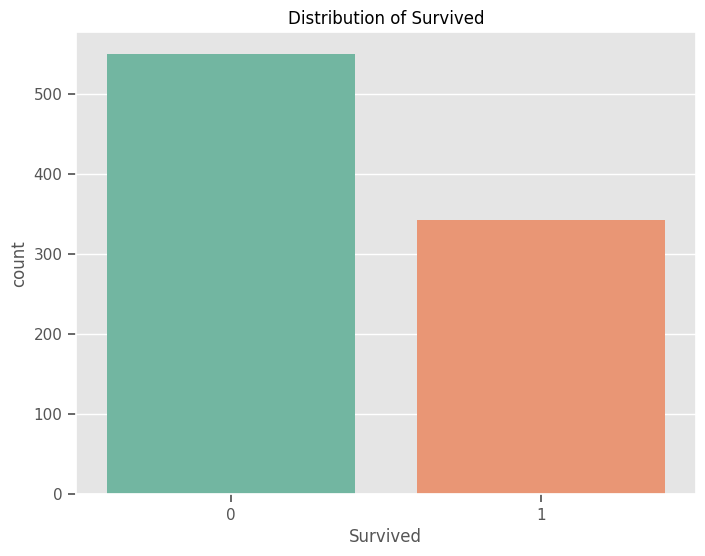

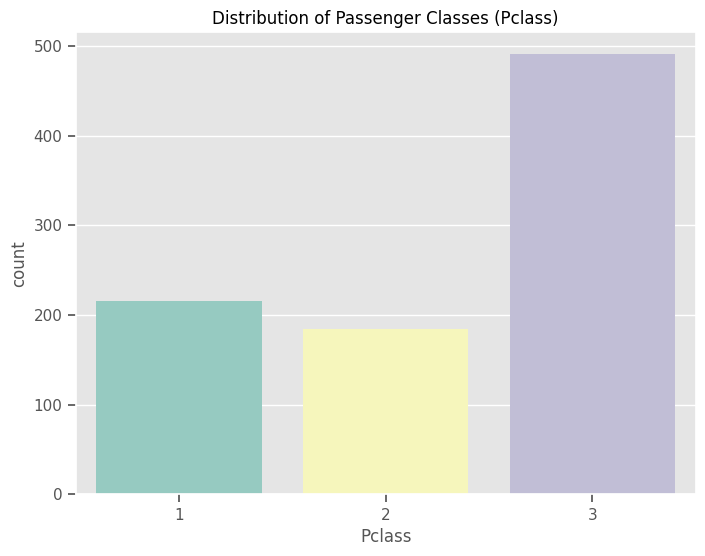

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


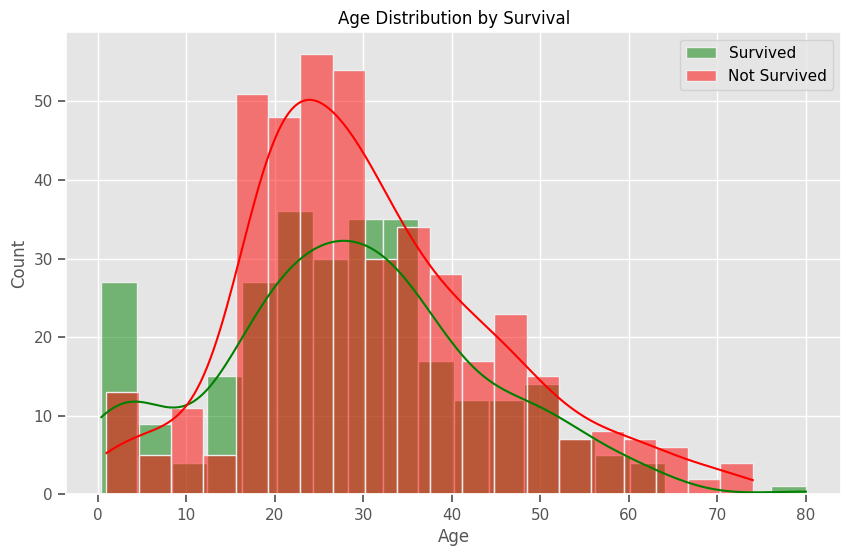

In [ ]:
# Step 4: Exploratory Data Analysis (EDA)
# Visualize distribution of 'Survived' feature in the training set
plt.figure(figsize=(8,6))
sns.countplot(data=train_df, x='Survived', palette='Set2')
plt.title('Distribution of Survived')
plt.show()

# Visualize class distribution (Pclass)
plt.figure(figsize=(8,6))
sns.countplot(data=train_df, x='Pclass', palette='Set3')
plt.title('Distribution of Passenger Classes (Pclass)')
plt.show()

# Distribution of age with respect to survival
plt.figure(figsize=(10,6))
sns.histplot(train_df[train_df['Survived'] == 1]['Age'].dropna(), bins=20, color='green', label='Survived', kde=True)
sns.histplot(train_df[train_df['Survived'] == 0]['Age'].dropna(), bins=20, color='red', label='Not Survived', kde=True)
plt.title('Age Distribution by Survival')
plt.legend()
plt.show()

# Correlation matrix to check relationships between numerical variables
# Filter only numeric columns
numeric_features = train_df.select_dtypes(include=[np.number])

plt.figure(figsize=(12,8))
sns.heatmap(numeric_features.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Data Preprocessing

In [ ]:
# Step 1: Handling missing values

# Filling missing 'Age' with the median of the corresponding 'Pclass' group
train_df['Age'] = train_df.groupby('Pclass')['Age'].transform(lambda x: x.fillna(x.median()))
test_df['Age'] = test_df.groupby('Pclass')['Age'].transform(lambda x: x.fillna(x.median()))

# Filling missing 'Embarked' with the most common value (mode)
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace=True)

# Filling missing 'Fare' in the test set with the median of the corresponding 'Pclass'
test_df['Fare'] = test_df.groupby('Pclass')['Fare'].transform(lambda x: x.fillna(x.median()))

In [ ]:
# Step 2: Feature engineering

# Creating a new feature 'FamilySize' by combining 'SibSp' (siblings/spouses) and 'Parch' (parents/children)
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch'] + 1

# Creating a new feature 'IsAlone': if the passenger is traveling alone or with family
train_df['IsAlone'] = 1  # Default value for alone
train_df['IsAlone'].loc[train_df['FamilySize'] > 1] = 0  # Not alone if FamilySize > 1
test_df['IsAlone'] = 1
test_df['IsAlone'].loc[test_df['FamilySize'] > 1] = 0

# Extracting 'Title' from 'Name' to use it as a feature
train_df['Title'] = train_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test_df['Title'] = test_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Simplifying 'Title' by replacing rare titles with 'Rare'
rare_titles = ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
train_df['Title'] = train_df['Title'].replace(rare_titles, 'Rare')
test_df['Title'] = test_df['Title'].replace(rare_titles, 'Rare')

# Grouping less common titles into 'Miss', 'Mrs', 'Mr', 'Master', and 'Rare'
train_df['Title'] = train_df['Title'].replace(['Mlle', 'Ms'], 'Miss')
train_df['Title'] = train_df['Title'].replace('Mme', 'Mrs')
test_df['Title'] = test_df['Title'].replace(['Mlle', 'Ms'], 'Miss')
test_df['Title'] = test_df['Title'].replace('Mme', 'Mrs')

In [ ]:
# Step 3: Encoding categorical variables

# Mapping 'Sex' to numerical values
train_df['Sex'] = train_df['Sex'].map({'male': 0, 'female': 1})
test_df['Sex'] = test_df['Sex'].map({'male': 0, 'female': 1})

# Mapping 'Embarked' to numerical values
train_df['Embarked'] = train_df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
test_df['Embarked'] = test_df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

# Encoding 'Title' as categorical
title_mapping = {'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master': 3, 'Rare': 4}
train_df['Title'] = train_df['Title'].map(title_mapping)
test_df['Title'] = test_df['Title'].map(title_mapping)

# Dropping irrelevant columns that won't be used in the modeling process
train_df = train_df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])
test_df = test_df.drop(columns=['Name', 'Ticket', 'Cabin'])

# Model Building

In [ ]:
# Step 1: Splitting the training data into features (X) and target (y)
X = train_df.drop(columns=['Survived'])
y = train_df['Survived']

# Splitting the training data into train and validation sets for model evaluation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to evaluate models
def evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    # Accuracy score
    accuracy = accuracy_score(y_val, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    
    # Confusion matrix and classification report
    print("Confusion Matrix:")
    print(confusion_matrix(y_val, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred))

    return model

In [11]:
# Step 2: Logistic Regression
print("\n--- Logistic Regression ---")
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg = evaluate_model(logreg, X_train, y_train, X_val, y_val)


--- Logistic Regression ---
Accuracy: 0.7877
Confusion Matrix:
[[86 19]
 [19 55]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       105
           1       0.74      0.74      0.74        74

    accuracy                           0.79       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



In [12]:
# Step 3: RandomForest
print("\n--- RandomForest Classifier ---")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf = evaluate_model(rf, X_train, y_train, X_val, y_val)


--- RandomForest Classifier ---
Accuracy: 0.8156
Confusion Matrix:
[[89 16]
 [17 57]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.84       105
           1       0.78      0.77      0.78        74

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



In [13]:
# Step 4: XGBoost Classifier
print("\n--- XGBoost Classifier ---")
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model = evaluate_model(xgb_model, X_train, y_train, X_val, y_val)


--- XGBoost Classifier ---
Accuracy: 0.8436
Confusion Matrix:
[[92 13]
 [15 59]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       105
           1       0.82      0.80      0.81        74

    accuracy                           0.84       179
   macro avg       0.84      0.84      0.84       179
weighted avg       0.84      0.84      0.84       179



In [14]:
# Step 5: Cross-validation to compare model performance
models = {
    'Logistic Regression': logreg,
    'RandomForest': rf,
    'XGBoost': xgb_model
}

print("\n--- Cross-Validation Scores ---")
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{name}: {scores.mean():.4f} (+/- {scores.std():.4f})")



--- Cross-Validation Scores ---
Logistic Regression: 0.8146 (+/- 0.0205)
RandomForest: 0.7992 (+/- 0.0195)
XGBoost: 0.8005 (+/- 0.0142)


# Hyperparameter Tuning

In [15]:
if HO_TUNING:
    # Step 1: Hyperparameter Tuning for Logistic Regression
    print("\n--- Hyperparameter Tuning: Logistic Regression ---")
    logreg_params = {
        'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
        'solver': ['liblinear', 'lbfgs'],  # Solver types
        'max_iter': [200, 500, 1000]  # Maximum iterations
    }

    logreg_grid = GridSearchCV(LogisticRegression(random_state=42), logreg_params, cv=5, scoring='accuracy')
    logreg_grid.fit(X_train, y_train)

    print(f"Best Hyperparameters for Logistic Regression: {logreg_grid.best_params_}")
    best_logreg = logreg_grid.best_estimator_

In [16]:
if HO_TUNING:
    # Save Logistic Regression model
    logreg_model_path = '/kaggle/working/models/logistic_regression_model.pkl'
    joblib.dump(best_logreg, logreg_model_path)
    print(f"Logistic Regression model saved to {logreg_model_path}")
    final_logreg = best_logreg

In [17]:
if HO_TUNING:
    # Step 2: Hyperparameter Tuning for RandomForest
    print("\n--- Hyperparameter Tuning: RandomForest ---")
    rf_params = {
        'n_estimators': [100, 200, 500],  # Number of trees in the forest
        'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
        'min_samples_split': [2, 10, 20],  # Minimum number of samples required to split
        'min_samples_leaf': [1, 5, 10],  # Minimum number of samples required in a leaf node
        'bootstrap': [True, False]  # Whether bootstrap samples are used
    }

    rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='accuracy')
    rf_grid.fit(X_train, y_train)

    print(f"Best Hyperparameters for RandomForest: {rf_grid.best_params_}")
    best_rf = rf_grid.best_estimator_

In [18]:
if HO_TUNING:
    # Save RandomForest model
    rf_model_path = '/kaggle/working/models/random_forest_model.pkl'
    joblib.dump(best_rf, rf_model_path)
    print(f"RandomForest model saved to {rf_model_path}")
    final_rf = best_rf

In [19]:
if HO_TUNING:
    # Step 3: Hyperparameter Tuning for XGBoost
    print("\n--- Hyperparameter Tuning: XGBoost ---")
    xgb_params = {
        'n_estimators': [100, 200, 500],  # Number of boosting rounds
        'max_depth': [3, 6, 10],  # Maximum depth of the trees
        'learning_rate': [0.01, 0.1, 0.2],  # Learning rate
        'subsample': [0.8, 1.0],  # Fraction of samples used for each tree
        'colsample_bytree': [0.8, 1.0]  # Fraction of features used for each tree
    }

    xgb_grid = GridSearchCV(xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), 
                            xgb_params, cv=5, scoring='accuracy')
    xgb_grid.fit(X_train, y_train)

    print(f"Best Hyperparameters for XGBoost: {xgb_grid.best_params_}")
    best_xgb = xgb_grid.best_estimator_

In [20]:
if HO_TUNING:
    # Save XGBoost model
    xgb_model_path = '/kaggle/working/models/xgboost_model.pkl'
    joblib.dump(best_xgb, xgb_model_path)
    print(f"XGBoost model saved to {xgb_model_path}")
    final_xgb = best_xgb

# Load the Models

In [21]:
if LOAD_MODEL:
    # Load Logistic Regression model
    logreg_model_path = '/kaggle/working/models/logistic_regression_model.pkl'
    final_logreg = joblib.load(logreg_model_path)
    print(f"Logistic Regression model loaded from {logreg_model_path}")

    # Load RandomForest model
    rf_model_path = '/kaggle/working/models/random_forest_model.pkl'
    final_rf = joblib.load(rf_model_path)
    print(f"RandomForest model loaded from {rf_model_path}")

    # Load XGBoost model
    xgb_model_path = '/kaggle/working/models/xgboost_model.pkl'
    final_xgb = joblib.load(xgb_model_path)
    print(f"XGBoost model loaded from {xgb_model_path}")

Logistic Regression model loaded from /kaggle/working/models/logistic_regression_model.pkl
RandomForest model loaded from /kaggle/working/models/random_forest_model.pkl
XGBoost model loaded from /kaggle/working/models/xgboost_model.pkl


# Model Comparison

In [22]:
print("\n--- Evaluating Best Models on Validation Set ---")
print("\nFinal Logistic Regression Performance:")
evaluate_model(final_logreg, X_train, y_train, X_val, y_val)

print("\nFinal RandomForest Performance:")
evaluate_model(final_rf, X_train, y_train, X_val, y_val)

print("\nFinal XGBoost Performance:")
evaluate_model(final_xgb, X_train, y_train, X_val, y_val)


--- Evaluating Best Models on Validation Set ---

Final Logistic Regression Performance:
Accuracy: 0.7933
Confusion Matrix:
[[87 18]
 [19 55]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.83      0.82       105
           1       0.75      0.74      0.75        74

    accuracy                           0.79       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.79      0.79      0.79       179


Final RandomForest Performance:


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8268
Confusion Matrix:
[[94 11]
 [20 54]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       105
           1       0.83      0.73      0.78        74

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.82       179


Final XGBoost Performance:
Accuracy: 0.8324
Confusion Matrix:
[[93 12]
 [18 56]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       105
           1       0.82      0.76      0.79        74

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

# Submission Preparation

In [23]:
# Step 1: Preparing the test set for prediction
# Ensure that the test set has the same feature columns as the training set (after preprocessing)
X_test = test_df.drop(columns=['PassengerId'])  # PassengerId will be used in the submission, so we drop it for prediction

In [24]:
# Step 2: Using the best model (XGBoost in this case) to make predictions on the test set
# You can replace `best_xgb` with `best_logreg` or `best_rf` if another model performed better during evaluation
final_model = final_xgb  # or best_rf, or best_logreg based on your selection
y_test_pred = final_model.predict(X_test)

In [25]:
# Step 3: Preparing the submission file
# Kaggle requires submission to have two columns: 'PassengerId' and 'Survived'
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': y_test_pred
})

# Save the submission file as a CSV
submission_file = 'submission.csv'
submission.to_csv(submission_file, index=False)

print(f"Submission file '{submission_file}' successfully created!")

Submission file 'submission.csv' successfully created!
